**Welcome to the Mini Challenge!**

In this notebook, your task is to explore and report on the decision-making process of a simple CNN model trained on an image classification task. The model, trained on a varient of the MNIST dataset (a 10-class classification problem), will be loaded below along with 10 example images.

Your goal is to apply various Explainable AI (XAI) techniques to understand how the model makes decisions. Keep in mind that some XAI methods are data-agnostic. Just because you learned them in a different context doesn't mean they can't be applied to image data.

For details on grading, please refer to the "Proof of Performance" section in the EAI space.

In [9]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import warnings # to suppress warnings
warnings.filterwarnings("ignore") # ignore warnings

In [17]:
# Define the CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
# Load the models best weights
model = SimpleCNN()
model.load_state_dict(torch.load('../models/challenge_model.pth'))
model.eval()

SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [46]:
# Load data and labels
challenge_images = np.load('../data/challenge_images.npy')
challenge_labels = np.load('../data/challenge_labels.npy')
print(f"Loaded challenge images: {challenge_images.shape}, labels: {challenge_labels.shape}")

Loaded challenge images: (10, 1, 28, 28), labels: (10,)


In [19]:
# YOUR CODE HERE


Accuracy of the network on the 10 challenge images: 0.0%


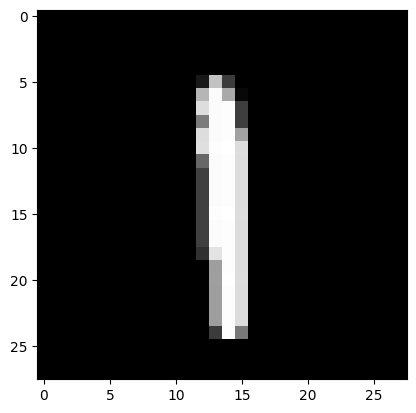

0
tensor([0])


In [49]:
indx = 4
im_array = challenge_images[indx].squeeze()
plt.imshow(im_array, cmap='gray')
plt.show()

image = torch.Tensor(challenge_images[indx]).unsqueeze(0)
label = challenge_labels[indx]
print(label)

# Get the predicted label
pred = model(image)
_, pred = torch.max(pred, 1)
print(pred)

In [45]:
challenge_labels

array([1, 3, 7, 2, 0, 4, 9, 5, 6, 8])